In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [49]:
df = pd.read_excel("../data/gmo_data.xlsx", sheet_name='total returns', parse_dates=['date']).set_index('date')

risk_free = pd.read_excel("../data/gmo_data.xlsx", sheet_name='risk-free rate', parse_dates=['date']).set_index('date')


excess_df = pd.DataFrame(columns=df.columns, index = df.index)
for col in df.columns:
    excess_df[col] = df[col] - risk_free['TBill 3M']

excess_df


,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.075002,-0.073804,-0.064710
1997-01-31,0.010316,-0.036735,-0.017022
1997-02-28,-0.042635,-0.029935,-0.039467
1997-03-31,-0.098941,-0.068372,-0.069661
1997-04-30,0.012038,-0.059061,-0.052330
...,...,...,...
2024-06-28,-0.018264,-0.060741,-0.066632
2024-07-31,-0.040731,-0.022440,-0.018159
2024-08-30,-0.027751,-0.036423,-0.031575


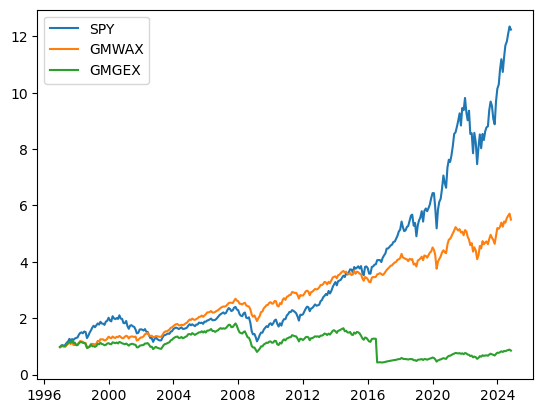

In [28]:
plt.plot(excess_df.index, (1+df['SPY']).cumprod(), label='SPY')
plt.plot(excess_df.index, (1+df['GMWAX']).cumprod(), label='GMWAX')
plt.plot(excess_df.index, (1+df['GMGEX']).cumprod(), label='GMGEX')
plt.legend()
plt.show()

In [29]:
first_sample = excess_df.loc[:'2012']
second_sample = excess_df.loc['2012':]


In [30]:
def getStats(returns, annulization = 12):
    df = pd.DataFrame(index = returns.columns)
    df['Mean'] = returns.mean() * annulization
    df['Vol'] = returns.std() * np.sqrt(annulization)
    df['Sharpe'] = df['Mean'] / df['Vol']
    df['Skew'] = returns.skew()
    df['Kurtoisis'] = returns.kurt()
    df['Min Return'] = returns.min()
    df['VaR'] = returns.quantile(0.05)
    df['CVaR'] = returns[returns <= returns.quantile(0.05, axis = 0)].mean()

    cumret = (1+returns).cumprod()
    
    cumMax = cumret.cummax()
    drawdown = (cumret - cumMax) / cumMax
    df['Max DD'] = drawdown.min()
    df['Bottom'] = drawdown.idxmin()
    tops = []
    recovery = []
    for column in cumMax.columns:
        cMax = cumMax[column]
        cRet = cumret[column]
        bottom = df['Bottom'].loc[column]
        top = cMax[(cMax == cRet) & (cMax.index < bottom)].index[-1]
        tops.append(top)
        recovered = cRet[(cRet >= cRet.loc[top]) & (cRet.index > bottom)]
        if len(recovered) == 0:
            recovery.append(None)
        else:
            recovery.append(recovered.index[0])
    df['Top'] = tops
    df['Recovery'] = recovery
    return df

first_sample_stats = getStats(pd.DataFrame(first_sample['GMWAX']))
first_sample_stats

second_sample_stats = getStats(pd.DataFrame(second_sample['GMWAX']))
second_sample_stats

full_sample_stats = getStats(pd.DataFrame(excess_df['GMWAX']))
full_sample_stats

stats = pd.concat([first_sample_stats, second_sample_stats, full_sample_stats])
stats.index = ['first sample', 'second sample', 'full sample']
stats

,Mean,Vol,Sharpe,Skew,Kurtoisis,Min Return,VaR,CVaR,Max DD,Bottom,Top,Recovery
first sample,-0.243030,0.131293,-1.851048,-0.657395,1.724617,-0.193379,-0.081986,-0.107633,-0.988490,2009-02-27,1996-12-31,None
second sample,-0.106196,0.111332,-0.953862,-0.667294,0.696895,-0.115577,-0.072478,-0.086671,-0.818206,2024-10-31,2015-02-27,None
full sample,-0.192155,0.124798,-1.539722,-0.683457,1.501332,-0.193379,-0.078500,-0.100016,-0.996149,2024-10-31,1996-12-31,None


In [54]:
def regress(returns, against, annulization = 52, n_betas = 1, beta_names = ['SPY']):
    against = against.copy()
    against = sm.add_constant(against)
    model = sm.OLS(returns, against).fit()
    r2 = model.rsquared
    alpha = model.params['const']
    tracking_error = model.resid.std()
    IR = alpha / tracking_error
    fitted_mean = model.fittedvalues.mean()
    sortino = returns.mean() / returns[returns < 0].std()
    stats = pd.DataFrame()
    stats['alpha'] = [alpha * annulization]
    betas = model.params.drop['const']
    for name, value in betas.items():
        stats[f"beta {name}"] = [value]
    treynors = None
    if len(betas) == 1:
        treynors = (returns.mean() / betas.values()[0])
    stats['tracking error'] = [tracking_error]
    stats['IR'] = [IR * np.sqrt(annulization)]
    stats['sortino'] = [sortino * np.sqrt(annulization)]
    stats['treynors'] = [treynors * annulization]
    stats['R-Squared'] = [r2]
    return stats

first_sample_regression_stats = regress(first_sample['GMWAX'], first_sample['SPY'], annulization=12)
second_sample_regression_stats = regress(second_sample['GMWAX'], second_sample['SPY'], annulization=12)
full_sample_regression_stats = regress(excess_df['GMWAX'], excess_df['SPY'], annulization=12)

regression_stats = pd.concat([first_sample_regression_stats, second_sample_regression_stats, full_sample_regression_stats])
regression_stats.index = ['first sample', 'second sample', 'full sample']
regression_stats

NameError: name 'beta' is not defined

In [45]:
gmgex_first_sample_regression_stats = regress(first_sample['GMGEX'], first_sample['SPY'], annulization=12)
gmgex_second_sample_regression_stats = regress(second_sample['GMGEX'], second_sample['SPY'], annulization=12)
gmgex_full_sample_regression_stats = regress(excess_df['GMGEX'], excess_df['SPY'], annulization=12)

gmgex_regression_stats = pd.concat([gmgex_first_sample_regression_stats, gmgex_second_sample_regression_stats, gmgex_full_sample_regression_stats])
gmgex_regression_stats.index = ['gmgex first sample', 'gmgex second sample', 'gmgex full sample']
gmgex_regression_stats

,alpha,beta,tracking error,IR,sortino,treynors,R-Squared
gmgex first sample,-0.085170,0.823878,0.022615,-1.087181,-2.405406,-0.353078,0.772607
gmgex second sample,-0.134610,0.824561,0.058649,-0.662567,-0.566891,-0.179862,0.279303
gmgex full sample,-0.111706,0.810187,0.043188,-0.746662,-1.274043,-0.294575,0.459311


In [46]:
signals = pd.read_excel("../data/gmo_data.xlsx", sheet_name='signals', parse_dates=['date']).set_index('date')

signals

,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,
1996-12-31,1.9651,19.6873,6.4180
1997-01-31,1.8455,20.8856,6.4940
1997-02-28,1.8502,21.0116,6.5520
1997-03-31,1.9427,18.4633,6.9030
1997-04-30,1.8430,19.6004,6.7180
...,...,...,...
2024-06-28,1.3271,25.5386,4.3961
2024-07-31,1.3205,25.7965,4.0296
2024-08-30,1.2990,25.5680,3.9034


In [53]:
print(df.columns)
print(df['SPY'])
dp_reg = regress(df['SPY'], signals['SPX DVD YLD'], annulization=12)
ep_reg = regress(df['SPY'], signals['SPX P/E'], annulization=12)
multi_reg = regress(df['SPY'], signals, annulization=12)

gmgex_regression_stats = pd.concat([gmgex_first_sample_regression_stats, gmgex_second_sample_regression_stats, gmgex_full_sample_regression_stats])
gmgex_regression_stats.index = ['gmgex first sample', 'gmgex second sample', 'gmgex full sample']
gmgex_regression_stats

regressions = pd.concat([dp_reg, ep_reg, multi_reg])
regressions.index = ['Div to Price Ratio', 'PE ratio', 'All three']
regressions

Index(['SPY', 'GMWAX', 'GMGEX'], dtype='object')
date
1996-12-31   -0.023292
1997-01-31    0.061786
1997-02-28    0.009565
1997-03-31   -0.045721
1997-04-30    0.064368
                ...   
2024-06-28    0.035285
2024-07-31    0.012109
2024-08-30    0.023366
2024-09-30    0.021009
2024-10-31   -0.008924
Name: SPY, Length: 335, dtype: float64


KeyError: 'SPY'